In [1]:
import numpy as np
import numpyro
from jax import random
from numpyro.infer import MCMC, HMC,NUTS
import fitsio
from multiprocessing import Pool
from astropy.table import Table
from astropy.io import fits
import fitsio
import jax.numpy as jnp
import matplotlib.pyplot as plt
from numpyro import handlers 
from jax import random, jit
import jax
import numpyro.distributions as dist
import fitting5
from astropy.cosmology import Planck18

In [2]:
print(jax.devices())

[cuda(id=0)]


In [3]:
array = np.array([1,2,3])
array1 = np.array([1,2,3,4])
array2 = np.array([1,2,3,4,5])
array1 = array1[:,None]
array2 = array2[:,None,None]
print((array+array1+array2).shape)
print()

(5, 4, 3)



In [4]:
# Verify the installation
print("JAX version:", jax.__version__)
print("JAX is using CUDA:", jax.lib.xla_bridge.get_backend().platform)

# Enable 64-bit floating point precision
jax.config.update("jax_enable_x64", True)

# Verify the update
print("jax_enable_x64:", jax.config.read("jax_enable_x64"))

JAX version: 0.4.30
JAX is using CUDA: gpu
jax_enable_x64: True


In [5]:
# Check available devices
print("Available devices:", jax.devices())

# Simple CPU computation test
x = jnp.array([1.0, 2.0, 3.0])
y = jax.device_put(x, jax.devices('gpu')[0])
z = y ** 2
print("Computation result:", z)

Available devices: [cuda(id=0)]
Computation result: [1. 4. 9.]


In [6]:
k = Table.read('/pscratch/sd/z/zhaozhon/DATASET/DESI-data/k1.csv',format='csv')
indice = np.isnan(k['k_rr']) | np.isinf(k['k_rr'])
#k_gg = k['k_gg'][~indice]
k_rr = k['k_rr'][~indice]

In [7]:
file = '/pscratch/sd/z/zhaozhon/DATASET/DESI-data/new_d.fits'
d = Table(fitsio.read(file))
SEL = np.where((d['Z'] > 2.3) & (d['Z'] < 2.8))[0]
print(d[SEL]['TARGETID'][16171])
print(d[SEL]['TARGETID'].shape)
TARGETID = d['TARGETID'][SEL][~indice]
#apr_mag_g = d['APP_MAG_G'][SEL][~indice]
#apr_mag_g_err = d['APP_MAGERR_G'][SEL][~indice]
apr_mag_r = d['APP_MAG_R'][SEL][~indice]
apr_mag_r_err = d['APP_MAGERR_R'][SEL][~indice]
z_desi = d['Z'][SEL][~indice]

39627637697547336
(168482,)


In [8]:
bad_tid = 39627637697547336

# Create mask to exclude the target
mask_good = TARGETID != bad_tid

# Apply to all arrays
TARGETID = TARGETID[mask_good]
apr_mag_r = apr_mag_r[mask_good]
apr_mag_r_err = apr_mag_r_err[mask_good]
z_desi = z_desi[mask_good]
k_rr = k_rr[mask_good]

In [9]:
d_desi = Planck18.distmod(z_desi).value

In [10]:
TARGETID, indices = np.unique(TARGETID, return_index=True)
#apr_mag_g = apr_mag_g[indices]
#apr_mag_g_err = apr_mag_g_err[indices]
apr_mag_r = apr_mag_r[indices]
apr_mag_r_err = apr_mag_r_err[indices]
d_desi = d_desi[indices]
z_desi = z_desi[indices]
#k_gg = k_gg[indices]
k_rr = k_rr[indices]

In [11]:
bad_tid = 39627637697547336

# Create mask to exclude the target
mask_good = TARGETID != bad_tid

# Apply to all arrays
TARGETID = TARGETID[mask_good]
apr_mag_r = apr_mag_r[mask_good]
apr_mag_r_err = apr_mag_r_err[mask_good]
z_desi = z_desi[mask_good]
k_rr = k_rr[mask_good]

In [12]:
# Assuming z_desi is your redshift array
filter_mask = (z_desi > 2.3) & (z_desi < 2.6)

# Apply the filter to all arrays
TARGETID = TARGETID[filter_mask]
#apr_mag_g = apr_mag_g[filter_mask]
#apr_mag_g_err = apr_mag_g_err[filter_mask]
apr_mag_r = apr_mag_r[filter_mask]
apr_mag_r_err = apr_mag_r_err[filter_mask]
d_desi = d_desi[filter_mask]
z_desi = z_desi[filter_mask]
#k_gg = k_gg[filter_mask]
k_rr = k_rr[filter_mask]

# Recalculate N_obs after filtering
N_obs = TARGETID.shape[0]
print(N_obs)

116959


In [13]:
#apr_mag_g = apr_mag_g.astype(np.float64)
#apr_mag_g_err = apr_mag_g_err.astype(np.float64)
#k_gg = k_gg.astype(np.float64)

apr_mag_r = apr_mag_r.astype(np.float64)
apr_mag_r_err = apr_mag_r_err.astype(np.float64)
k_rr = k_rr.astype(np.float64)

d_desi = d_desi.astype(np.float64)
z_desi = z_desi.astype(np.float64)

In [14]:
apr_mag_r = jnp.array(apr_mag_r)
apr_mag_r_err = jnp.array(apr_mag_r_err)
k_rr = jnp.array(k_rr)
d_desi = jnp.array(d_desi)
z_desi = jnp.array(z_desi)

In [15]:
gamma1_shen20, gamma2_shen20, L_star_shen20, phi_star_shen20 = fitting5.get_lfpars_shen20(2.35)
alpha_shen20 = -(gamma1_shen20+1)
beta_shen20 = -(gamma2_shen20+1)

In [16]:
print(gamma1_shen20, gamma2_shen20, L_star_shen20, phi_star_shen20)

0.4101099999999999 2.50877883045515 4.5433620711936776e+46 1.37670217962694e-05


In [17]:
#def eff(m,b,m0):
#    eff = jnp.where(m < m0, 1,jnp.where(m < 23.1,10**(-b*(m-m0)/2.5),0))
#    return eff
def eff(m,b,m0):
    eff = jnp.where(m<m0,1,10**(-b*(m-m0)/2.5))
    return eff

ln_posterior = fitting5.ln_posterior(eff)
ln_posterior2 = fitting5.ln_posterior2(eff)

def model(apr_mag, sigma, k, mu, z):
    # Efficiency function parameters
    m0 = numpyro.sample('m0', dist.Uniform(0, 30))
    b = numpyro.sample('b', dist.Uniform(0, 5))

    # Redshift-evolving L_star(z) = 10^(aL z^2 + bL z + cL)
    aL = numpyro.sample('aL', dist.Uniform(-20, 20))
    bL = numpyro.sample('bL', dist.Uniform(-20, 20))
    cL = numpyro.sample('cL', dist.Uniform(36, 56))

    # Redshift-evolving phi_star(z) = 10^(aP z^2 + bP z + cP)
    aP = numpyro.sample('aP', dist.Uniform(-20, 20))
    bP = numpyro.sample('bP', dist.Uniform(-20, 20))
    cP = numpyro.sample('cP', dist.Uniform(-10, 0))
    
    # Redshift-evolving beta(z) = a_beta * z + b_beta
    a_beta = numpyro.sample('a_beta', dist.Uniform(-5, 5))
    b_beta = numpyro.sample('b_beta', dist.Uniform(-4, -2))
    
    # Redshift-evolving alpha(z) = a_alpha * z + b_alpha
    a_alpha = numpyro.sample('a_alpha', dist.Uniform(-5, 5))
    b_alpha = numpyro.sample('b_alpha', dist.Uniform(b_beta, 0))

    # Evolutionary magnitude correction term

    # Evaluate log-likelihood
    log_likelihood = ln_posterior2(
        m0, b,
        aL, bL, cL,
        aP, bP, cP,
        a_alpha, b_alpha,
        a_beta, b_beta,
        apr_mag, sigma, k, mu, z
    )

    numpyro.factor("log_likelihood", log_likelihood)

In [18]:
'''
import numpy as np

# Define ranges to test
m0_values = [10, 15, 19]
b_values = [0.01, 0.1, 1]
x_values = [1.4, 1.6, 1.8]

# Loop over combinations
for m0 in m0_values:
    for b in b_values:
        for x in x_values:
            logp = ln_posterior(m0, b, x, apr_mag_r, k_rr, d_desi, 0.014)
            logp1 = ln_posterior1(m0, b, x, apr_mag_r, k_rr, d_desi, 0.014)
            print(f"m0={m0}, b={b}, x={x} -> logp={logp:.4f}, logp1={logp1:.4f}, diff={logp1 - logp:.4f}")
'''

'\nimport numpy as np\n\n# Define ranges to test\nm0_values = [10, 15, 19]\nb_values = [0.01, 0.1, 1]\nx_values = [1.4, 1.6, 1.8]\n\n# Loop over combinations\nfor m0 in m0_values:\n    for b in b_values:\n        for x in x_values:\n            logp = ln_posterior(m0, b, x, apr_mag_r, k_rr, d_desi, 0.014)\n            logp1 = ln_posterior1(m0, b, x, apr_mag_r, k_rr, d_desi, 0.014)\n            print(f"m0={m0}, b={b}, x={x} -> logp={logp:.4f}, logp1={logp1:.4f}, diff={logp1 - logp:.4f}")\n'

In [19]:
rng_key = random.PRNGKey(0)
# Sampler configuration
num_warmup, num_samples = 10000, 10000
i_start = 0
i_end = i_start+np.shape(apr_mag_r)[0]
#i_end = 1000
# Initialize batch parameters for the entire dataset

init_params = {
    'x': 1.5 * jnp.ones((1,)),  
    'm0': 18 * jnp.ones((1,)),
    'b': 0.5 * jnp.ones((1,)),
}

# Set up the NUTS sampler
kernel = NUTS(model, target_accept_prob=0.8)
#kernel = HMC(model)
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=1,jit_model_args=True, progress_bar=True)

# Run the sampler over thswwe entire dataset
#mcmc.run(rng_key, apr_mag_g, apr_mag_g _err, k_gg, apr_mag_r, apr_mag_r_err, k_rr, d,z, 22.5, init_params=init_params)
mcmc.run(rng_key, apr_mag_r[i_start:i_end],apr_mag_r_err[i_start:i_end],k_rr[i_start:i_end],d_desi[i_start:i_end],z_desi[i_start:i_end])
# Get samples
samples = mcmc.get_samples()
# Optionally, process or save your samples
print(samples)

sample: 100%|██████████| 20000/20000 [21:29<00:00, 15.50it/s, 127 steps of size 4.83e-02. acc. prob=0.93] 


{'aL': Array([-1.15955003, -0.9886332 , -1.66809486, ..., -0.59219863,
       -1.73661366, -1.04502833], dtype=float64), 'aP': Array([ 0.4033292 ,  0.44208059,  0.36227715, ..., -0.25549958,
        0.41989127,  0.48522349], dtype=float64), 'a_alpha': Array([0.04479892, 0.17393611, 0.1543709 , ..., 0.34005229, 0.10683939,
       0.10864355], dtype=float64), 'a_beta': Array([0.63701167, 0.57542926, 0.1714582 , ..., 0.63102826, 0.29289098,
       0.16842969], dtype=float64), 'b': Array([0.48372843, 0.47289495, 0.44912227, ..., 0.45647654, 0.4531632 ,
       0.45583536], dtype=float64), 'bL': Array([ 0.11554809,  0.16561457,  0.26211663, ..., -0.0153923 ,
        0.23001635,  0.21271222], dtype=float64), 'bP': Array([0.18661628, 0.1736476 , 0.14184163, ..., 0.35719868, 0.12223556,
       0.15037195], dtype=float64), 'b_alpha': Array([-1.11286203, -1.11817025, -1.08373951, ..., -1.09183848,
       -1.07442317, -1.11453976], dtype=float64), 'b_beta': Array([-2.89237669, -2.87556774, -2.8628

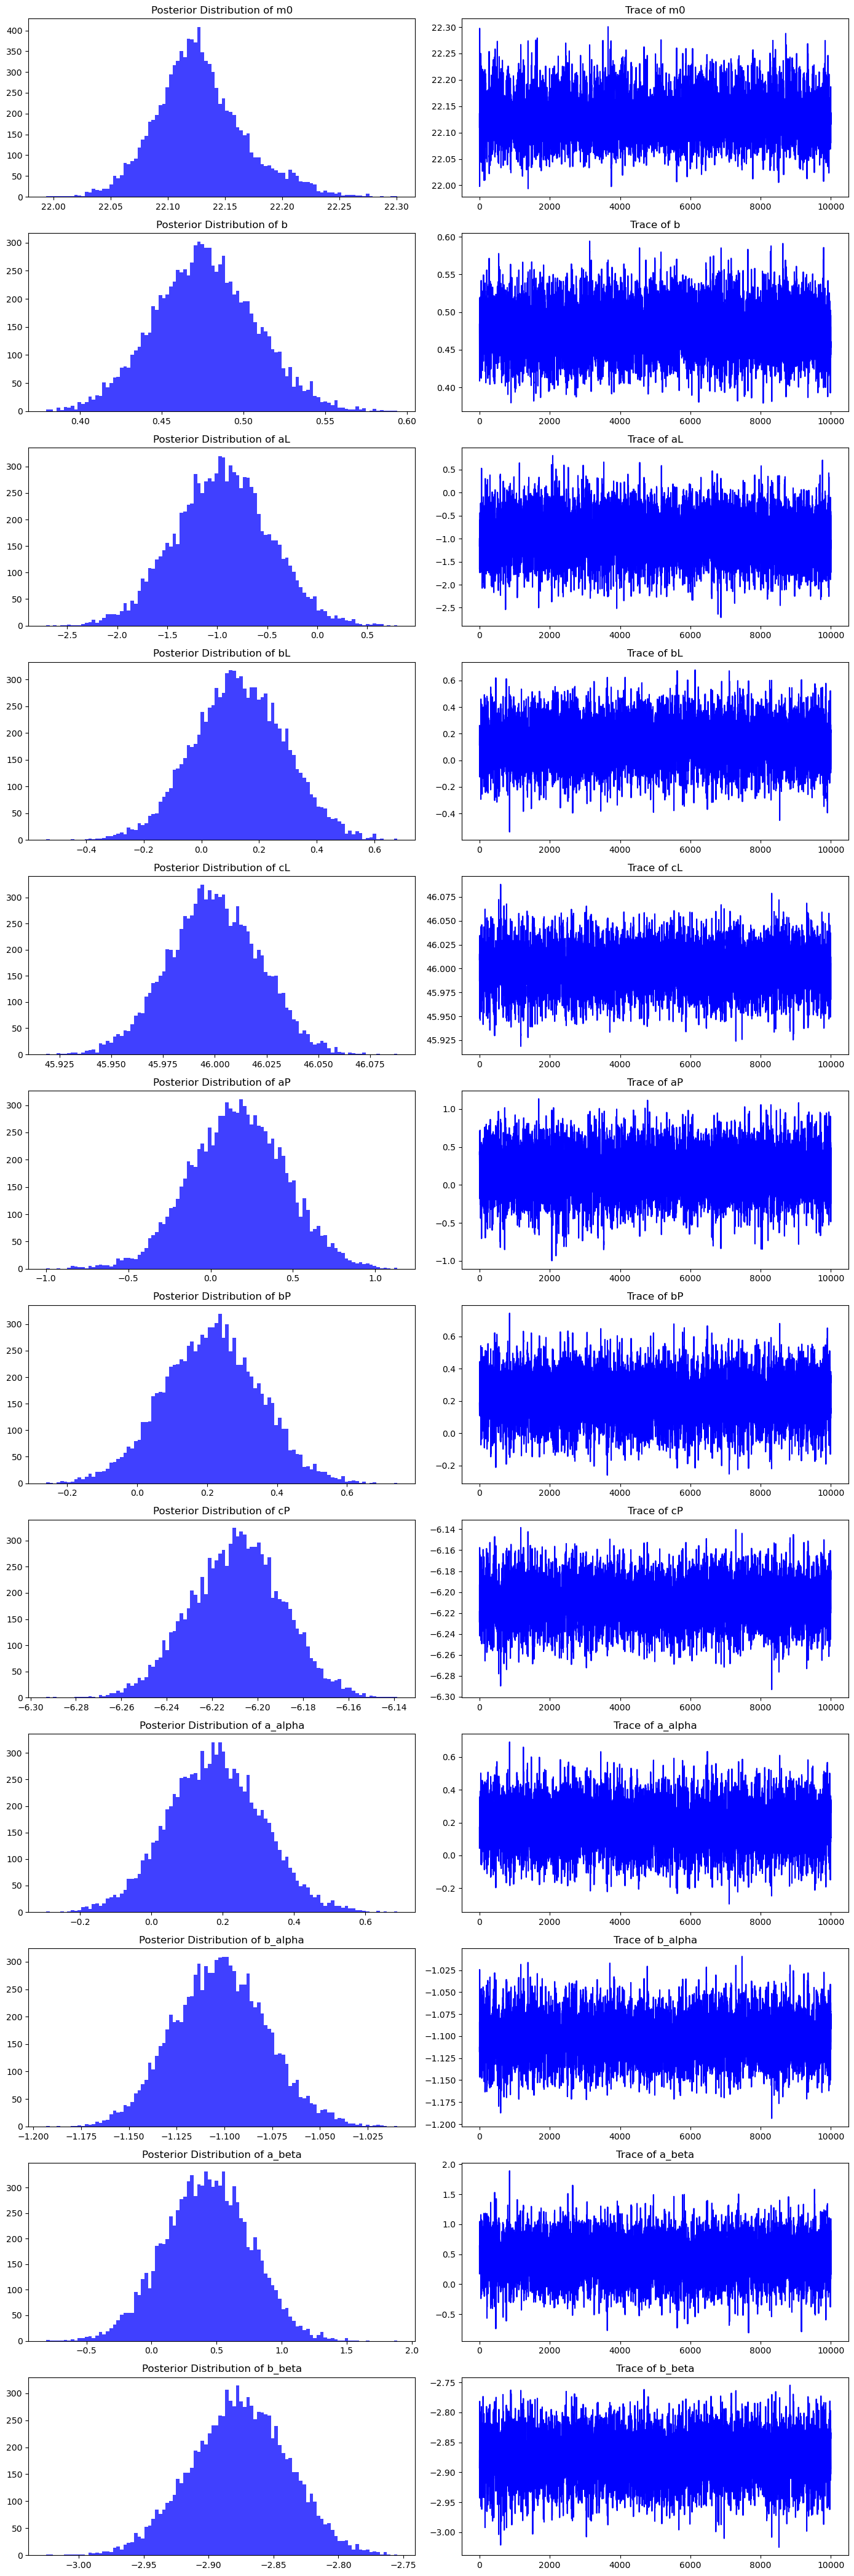

In [20]:
# Extract samples and save
samples = mcmc.get_samples()
np.savez("/pscratch/sd/z/zhaozhon/MCMC/mcmc_samples_evolution.npz", **samples)

# Extract individual parameters
m0 = samples['m0']
b = samples['b']
aL = samples['aL']
bL = samples['bL']
cL = samples['cL']
aP = samples['aP']
bP = samples['bP']
cP = samples['cP']
a_alpha = samples['a_alpha']
b_alpha = samples['b_alpha']
a_beta = samples['a_beta']
b_beta = samples['b_beta']

# Extract individual parameters
params = {
    'm0': samples['m0'],
    'b': samples['b'],
    'aL': samples['aL'],
    'bL': samples['bL'],
    'cL': samples['cL'],
    'aP': samples['aP'],
    'bP': samples['bP'],
    'cP': samples['cP'],
    'a_alpha': samples['a_alpha'],
    'b_alpha': samples['b_alpha'],
    'a_beta': samples['a_beta'],
    'b_beta': samples['b_beta'],
}

# Set up grid for 14 parameters
fig, axs = plt.subplots(nrows=12, ncols=2, figsize=(14, 42))
axs = axs.reshape(12, 2)

# Helper function
def plot_param(ax, data, title):
    ax[0].hist(data, bins=100, alpha=0.75, color='blue')
    ax[0].set_title(f'Posterior Distribution of {title}')
    ax[1].plot(data, color='blue')
    ax[1].set_title(f'Trace of {title}')

# Plot each parameter
for i, (name, values) in enumerate(params.items()):
    plot_param(axs[i], values, name)

plt.tight_layout()
plt.show()


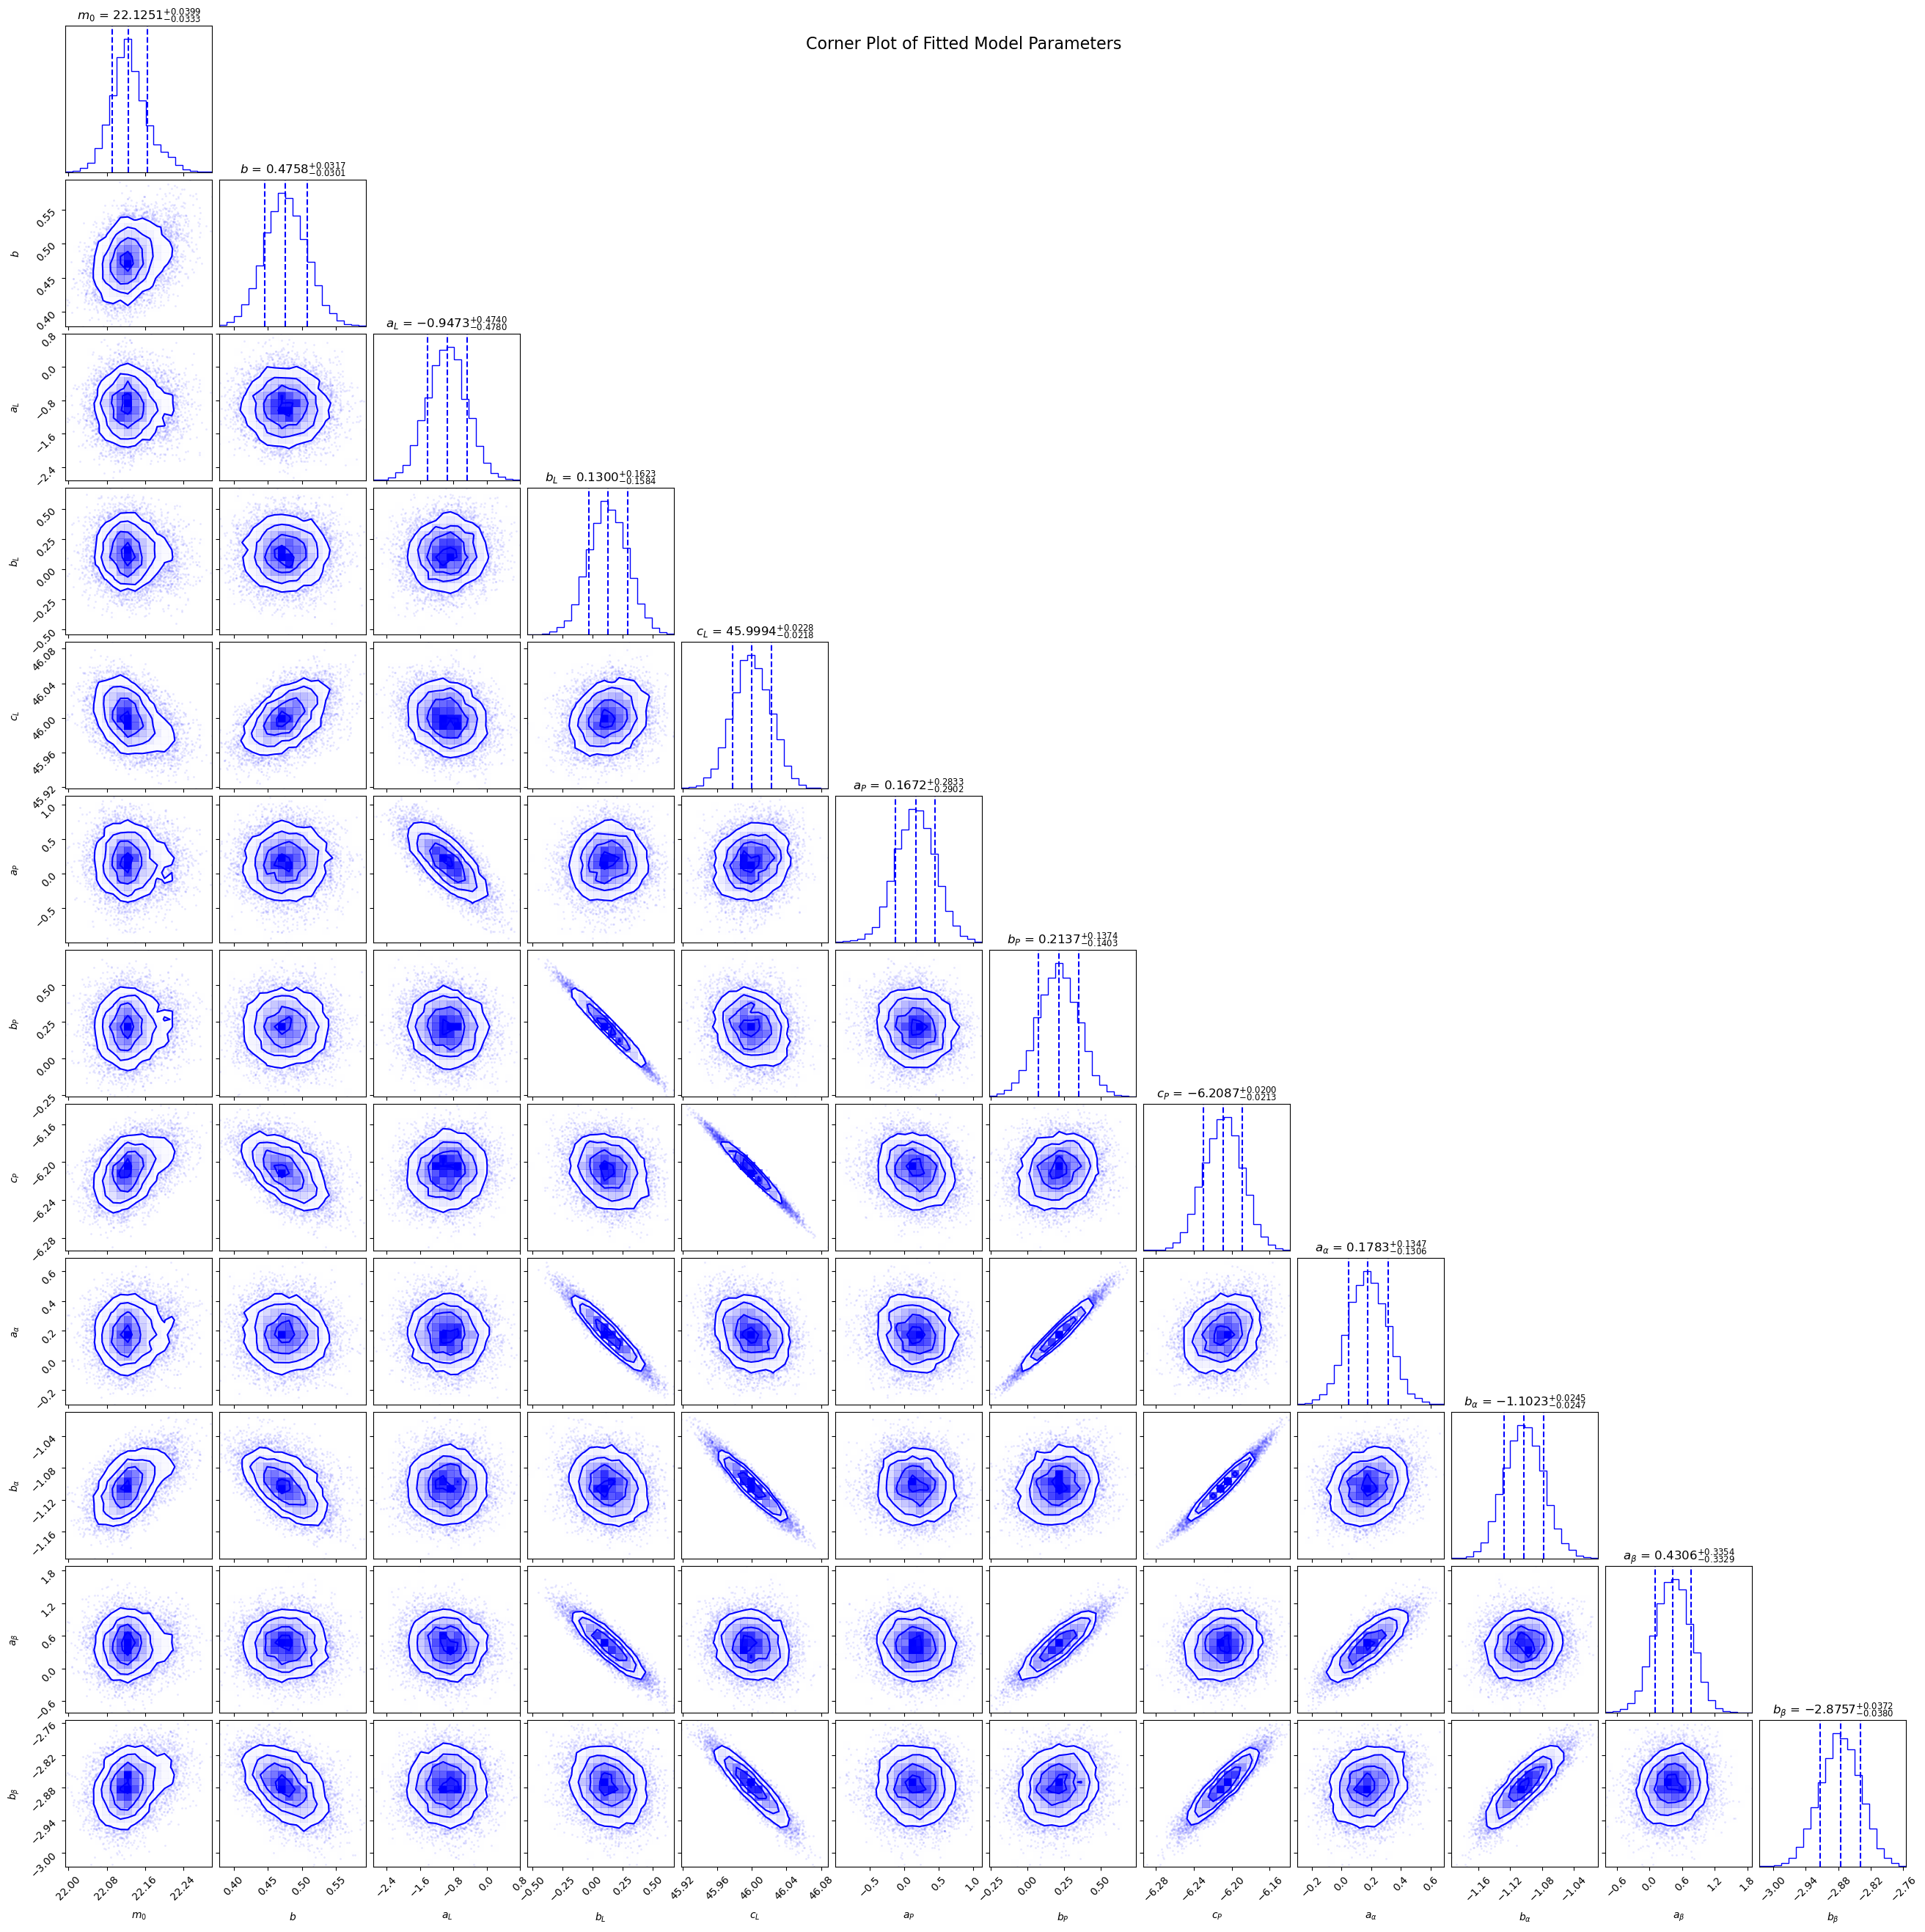

In [21]:
import corner

# Extract samples
samples = mcmc.get_samples()

# Stack only the parameters you directly fit
samples_array = np.vstack((
    samples['m0'],
    samples['b'],
    samples['aL'], samples['bL'], samples['cL'],
    samples['aP'], samples['bP'], samples['cP'],
    samples['a_alpha'], samples['b_alpha'],
    samples['a_beta'], samples['b_beta']
)).T

# Label each dimension
labels = [
    r"$m_0$", r"$b$",
    r"$a_L$", r"$b_L$", r"$c_L$",
    r"$a_P$", r"$b_P$", r"$c_P$",
    r"$a_{\alpha}$", r"$b_{\alpha}$",
    r"$a_{\beta}$", r"$b_{\beta}$"
]

# Create corner plot
fig = corner.corner(
    samples_array, labels=labels,
    show_titles=True, quantiles=[0.16, 0.5, 0.84],
    plot_contours=True, color='blue',
    title_kwargs={"fontsize": 12}, title_fmt=".4f"
)

fig.suptitle('Corner Plot of Fitted Model Parameters', fontsize=16)
plt.show()


In [22]:
Planck18.comoving_volume(1)

<Quantity 1.64002856e+11 Mpc3>

array([[<Axes: title={'center': 'aL'}>, <Axes: title={'center': 'aL'}>],
       [<Axes: title={'center': 'aP'}>, <Axes: title={'center': 'aP'}>],
       [<Axes: title={'center': 'a_alpha'}>,
        <Axes: title={'center': 'a_alpha'}>],
       [<Axes: title={'center': 'a_beta'}>,
        <Axes: title={'center': 'a_beta'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>],
       [<Axes: title={'center': 'bL'}>, <Axes: title={'center': 'bL'}>],
       [<Axes: title={'center': 'bP'}>, <Axes: title={'center': 'bP'}>],
       [<Axes: title={'center': 'b_alpha'}>,
        <Axes: title={'center': 'b_alpha'}>],
       [<Axes: title={'center': 'b_beta'}>,
        <Axes: title={'center': 'b_beta'}>],
       [<Axes: title={'center': 'cL'}>, <Axes: title={'center': 'cL'}>],
       [<Axes: title={'center': 'cP'}>, <Axes: title={'center': 'cP'}>],
       [<Axes: title={'center': 'm0'}>, <Axes: title={'center': 'm0'}>]],
      dtype=object)

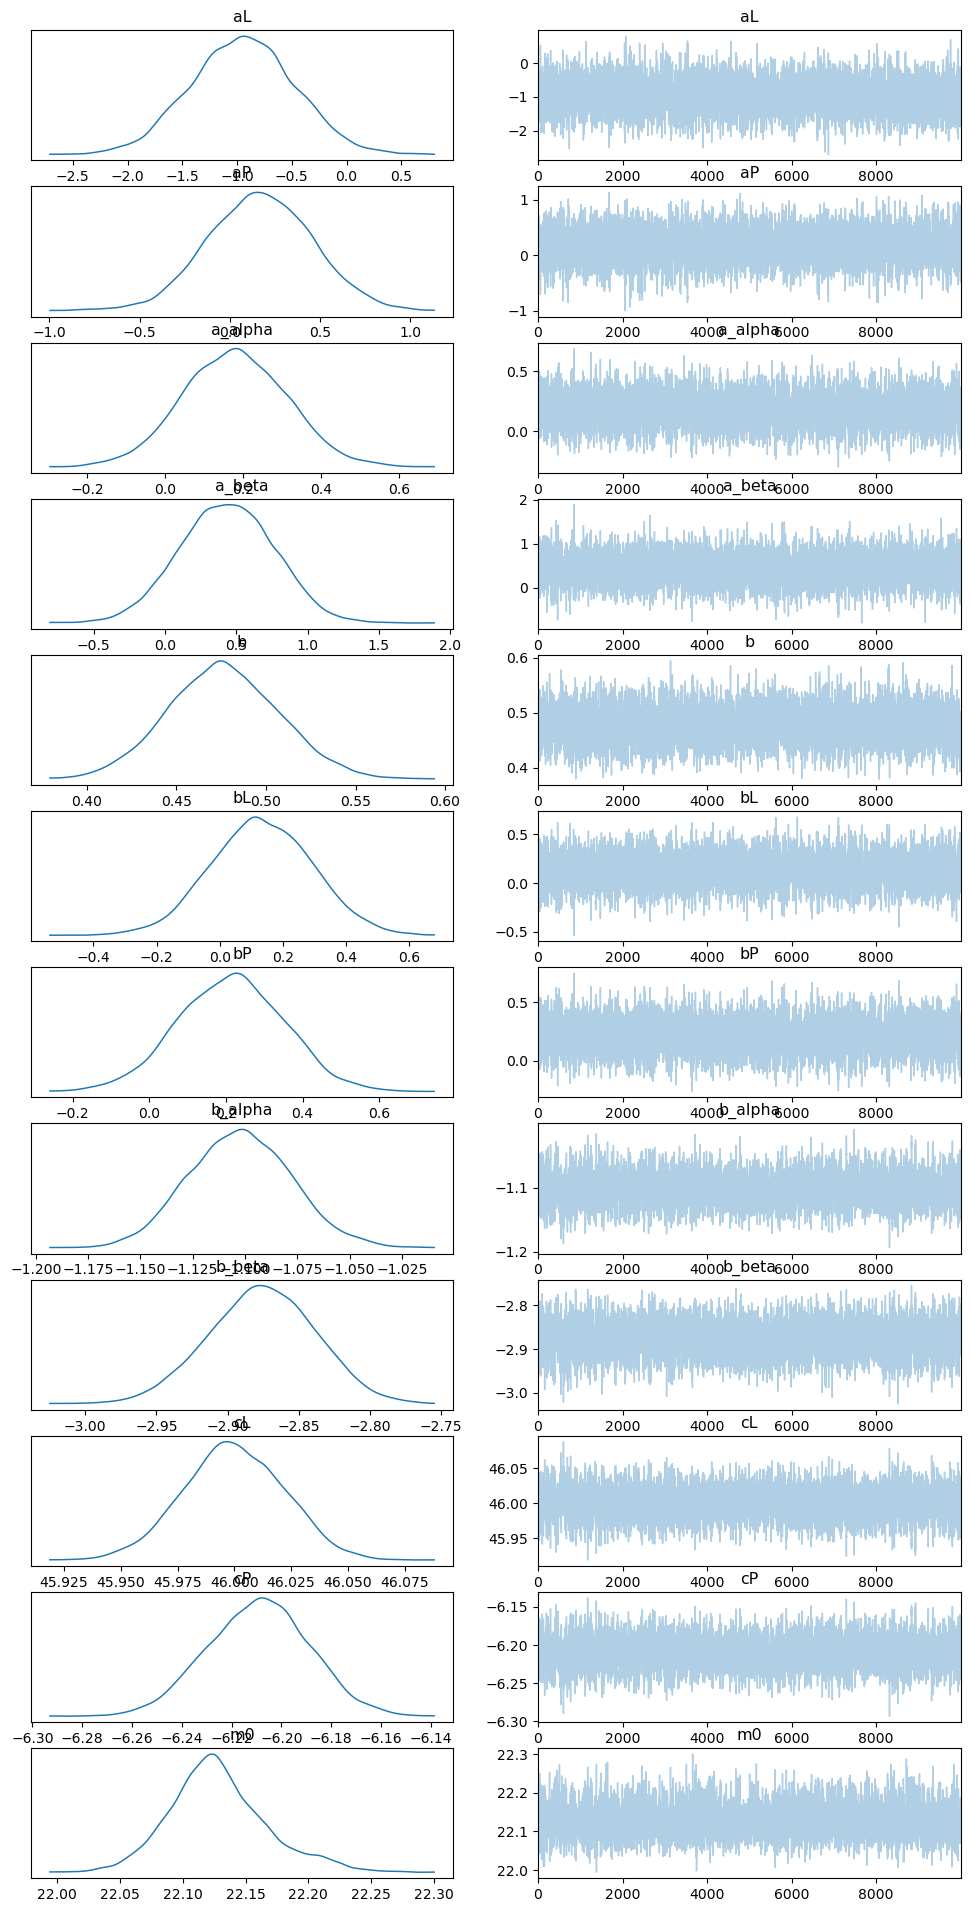

In [23]:
import arviz as az
az.plot_trace(mcmc)

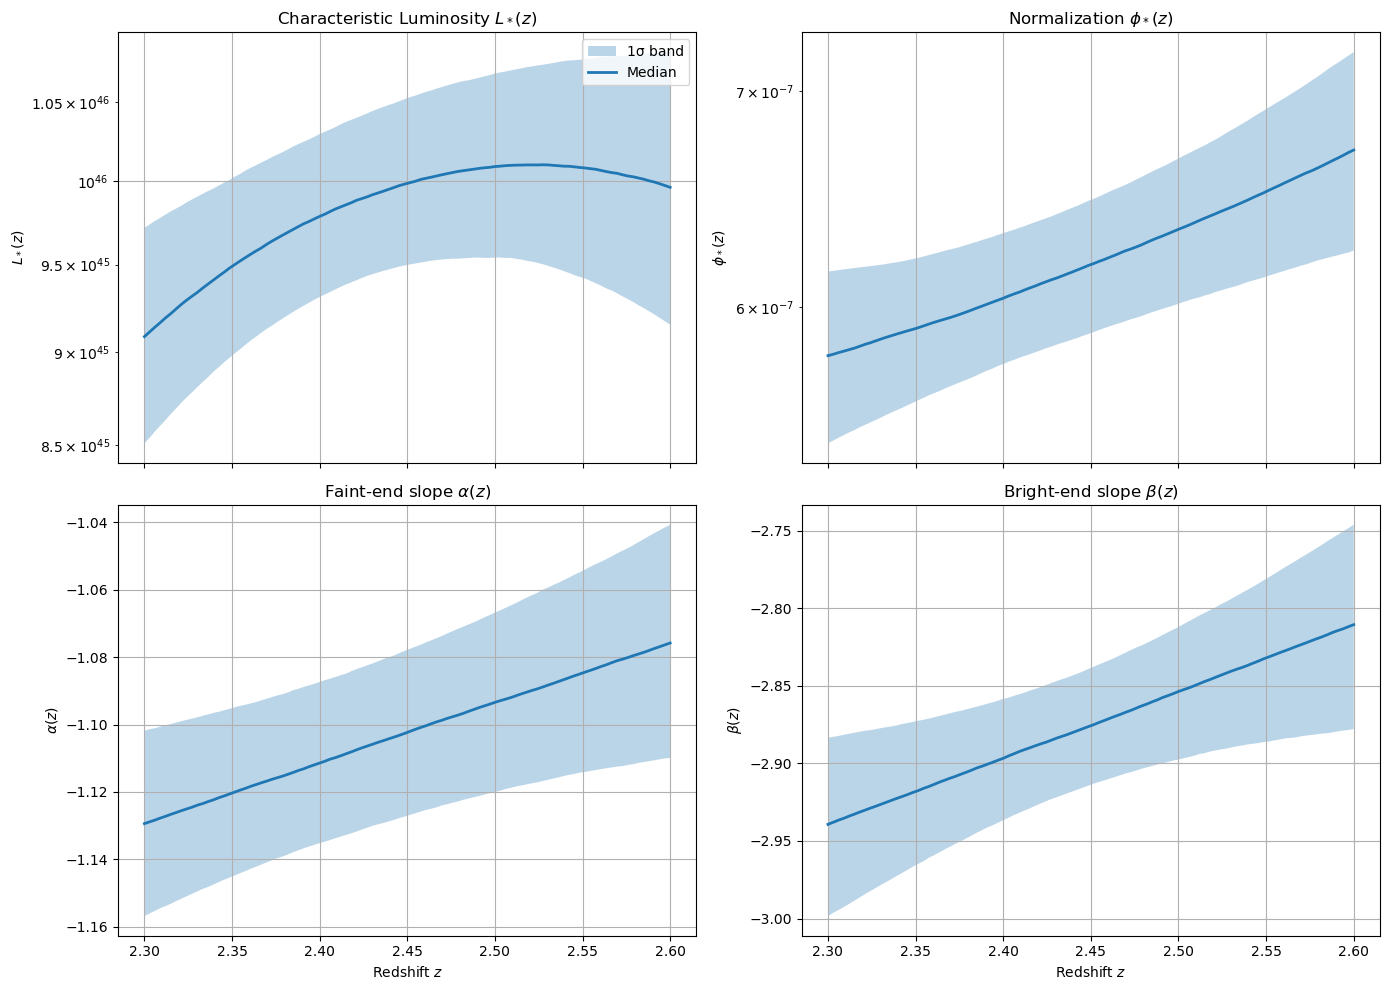

In [24]:
# Derived quantities (optional)
z_grid = np.linspace(2.3, 2.6, 100)
L_star_z = 10 ** (aL[:, None] * (z_grid-2.45)**2 + bL[:, None] * (z_grid-2.45) + cL[:, None])
phi_star_z = 10 ** (aP[:, None] * (z_grid-2.45)**2 + bP[:, None] * (z_grid-2.45) + cP[:, None])
alpha_z = a_alpha[:, None] * (z_grid-2.45) + b_alpha[:, None]
beta_z = a_beta[:, None] * (z_grid-2.45) + b_beta[:, None]

# Compute percentiles for each parameter across redshift grid
def get_percentiles(samples_z):
    median = np.median(samples_z, axis=0)
    p16 = np.percentile(samples_z, 16, axis=0)
    p84 = np.percentile(samples_z, 84, axis=0)
    return median, p16, p84

# Get percentiles
L_median, L_p16, L_p84 = get_percentiles(L_star_z)
phi_median, phi_p16, phi_p84 = get_percentiles(phi_star_z)
alpha_median, alpha_p16, alpha_p84 = get_percentiles(alpha_z)
beta_median, beta_p16, beta_p84 = get_percentiles(beta_z)

# Plot all in one figure
fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

# L_*(z)
axs[0, 0].fill_between(z_grid, L_p16, L_p84, alpha=0.3, label='1σ band')
axs[0, 0].plot(z_grid, L_median, lw=2, label='Median')
axs[0, 0].set_yscale('log')
axs[0, 0].set_ylabel(r"$L_*(z)$")
axs[0, 0].set_title("Characteristic Luminosity $L_*(z)$")
axs[0, 0].legend()
axs[0, 0].grid(True)

# phi_*(z)
axs[0, 1].fill_between(z_grid, phi_p16, phi_p84, alpha=0.3)
axs[0, 1].plot(z_grid, phi_median, lw=2)
axs[0, 1].set_yscale('log')
axs[0, 1].set_ylabel(r"$\phi_*(z)$")
axs[0, 1].set_title("Normalization $\\phi_*(z)$")
axs[0, 1].grid(True)

# alpha(z)
axs[1, 0].fill_between(z_grid, alpha_p16, alpha_p84, alpha=0.3)
axs[1, 0].plot(z_grid, alpha_median, lw=2)
axs[1, 0].set_ylabel(r"$\alpha(z)$")
axs[1, 0].set_title("Faint-end slope $\\alpha(z)$")
axs[1, 0].set_xlabel("Redshift $z$")
axs[1, 0].grid(True)

# beta(z)
axs[1, 1].fill_between(z_grid, beta_p16, beta_p84, alpha=0.3)
axs[1, 1].plot(z_grid, beta_median, lw=2)
axs[1, 1].set_ylabel(r"$\beta(z)$")
axs[1, 1].set_title("Bright-end slope $\\beta(z)$")
axs[1, 1].set_xlabel("Redshift $z$")
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()
